In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df=pd.read_csv('/Data/train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [2]:
df['Gender'] = df['Gender'].fillna( df['Gender'].dropna().mode().values[0] )
df['Married'] = df['Married'].fillna( df['Married'].dropna().mode().values[0] )
df['Dependents'] = df['Dependents'].fillna( df['Dependents'].dropna().mode().values[0] )
df['Self_Employed'] = df['Self_Employed'].fillna( df['Self_Employed'].dropna().mode().values[0] )
df['LoanAmount'] = df['LoanAmount'].fillna( df['LoanAmount'].dropna().mean())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna( df['Loan_Amount_Term'].dropna().mode().values[0] )
df['Credit_History'] = df['Credit_History'].fillna( df['Credit_History'].dropna().mode().values[0] )

df['Dependents'] = df['Dependents'].str.rstrip('+')

df['Gender'] = df['Gender'].map({'Female':0,'Male':1}).astype(np.int)
df['Married'] = df['Married'].map({'No':0, 'Yes':1}).astype(np.int)
df['Education'] = df['Education'].map({'Not Graduate':0, 'Graduate':1}).astype(np.int)
df['Self_Employed'] = df['Self_Employed'].map({'No':0, 'Yes':1}).astype(np.int)
df['Loan_Status'] = df['Loan_Status'].map({'N':0, 'Y':1}).astype(np.int)
df['Dependents'] = df['Dependents'].astype(np.int)

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,1,0,5849,0.0,146.412162,360.0,1.0,Urban,1
1,LP001003,1,1,1,1,0,4583,1508.0,128.000000,360.0,1.0,Rural,0
2,LP001005,1,1,0,1,1,3000,0.0,66.000000,360.0,1.0,Urban,1
3,LP001006,1,1,0,0,0,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,LP001008,1,0,0,1,0,6000,0.0,141.000000,360.0,1.0,Urban,1


In [4]:
dtrain= pd.get_dummies(df)

In [13]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV 
train = dtrain
target = 'Loan_Status'
IDcol = 'Loan_ID'

In [14]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Loan_Status'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Loan_Status'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Loan_Status'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8648
AUC Score (Train): 0.963437


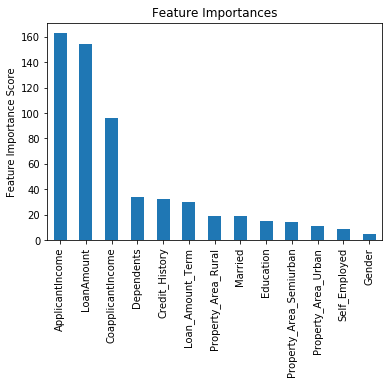

In [15]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb1, train, predictors)

In [18]:

param_test1 = { 'max_depth':list(range(3,10,2)), 'min_child_weight':list(range(1,6,2))}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,   objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc',iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.74539, std: 0.05113, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.74725, std: 0.05122, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.75823, std: 0.04397, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.74895, std: 0.05216, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.75256, std: 0.04150, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.76303, std: 0.04382, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.75599, std: 0.05445, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.75270, std: 0.04754, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.76366, std: 0.04848, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.75371, std: 0.04636, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.75607, std: 0.04322, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.75878, std: 0.04897, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weight': 5

In [19]:
param_test2 = { 'max_depth':[6,7,8], 'min_child_weight':[4,5,6] }
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.75922, std: 0.04633, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.76296, std: 0.04681, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.76698, std: 0.04159, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: 0.75485, std: 0.04938, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.76366, std: 0.04848, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.76172, std: 0.03929, params: {'max_depth': 7, 'min_child_weight': 6},
  mean: 0.75832, std: 0.04803, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: 0.75659, std: 0.05086, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: 0.76053, std: 0.04073, params: {'max_depth': 8, 'min_child_weight': 6}],
 {'max_depth': 6, 'min_child_weight': 6},
 0.76697734154390507)

In [20]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=8,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76053, std: 0.04073, params: {'min_child_weight': 6},
  mean: 0.76277, std: 0.03768, params: {'min_child_weight': 8},
  mean: 0.76017, std: 0.03822, params: {'min_child_weight': 10},
  mean: 0.76361, std: 0.03437, params: {'min_child_weight': 12}],
 {'min_child_weight': 12},
 0.76360927771918485)

In [21]:
param_test2c = {
 'min_child_weight':[11,12,13]
}
gsearch2c = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=8,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',iid=False, cv=5)
gsearch2c.fit(train[predictors],train[target])
gsearch2c.grid_scores_, gsearch2c.best_params_, gsearch2c.best_score_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76053, std: 0.04073, params: {'min_child_weight': 6},
  mean: 0.76277, std: 0.03768, params: {'min_child_weight': 8},
  mean: 0.76017, std: 0.03822, params: {'min_child_weight': 10},
  mean: 0.76361, std: 0.03437, params: {'min_child_weight': 12}],
 {'min_child_weight': 12},
 0.76360927771918485)

In [22]:
#Updated max_depth=6 and min_child_weight=12
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=12, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76361, std: 0.03437, params: {'gamma': 0.0},
  mean: 0.76154, std: 0.03597, params: {'gamma': 0.1},
  mean: 0.75856, std: 0.03908, params: {'gamma': 0.2},
  mean: 0.75679, std: 0.03306, params: {'gamma': 0.3},
  mean: 0.76154, std: 0.03706, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.76360927771918485)


Model Report
Accuracy : 0.8094
AUC Score (Train): 0.863108


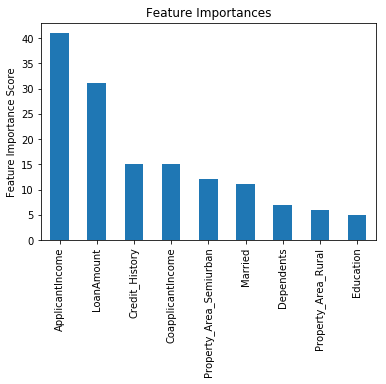

In [23]:
#Update gamma=0.0

xgb2 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=6, min_child_weight=12, gamma=0.0, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb2, train, predictors)

In [26]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
 min_child_weight=12, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61484, std: 0.07547, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.75851, std: 0.02373, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.75624, std: 0.03465, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.76130, std: 0.03805, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.60745, std: 0.07966, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.75837, std: 0.03010, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.76104, std: 0.03528, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.76094, std: 0.03850, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.60889, std: 0.07764, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.75658, std: 0.02996, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.76334, std: 0.03602, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.76523, std: 0.03978, params: {'colsample_bytree': 0.8, 'subsample'

In [27]:
param_test4a = {
 'subsample':[i/10.0 for i in range(8,12)],
 'colsample_bytree':[i/10.0 for i in range(9,12)]
}
gsearch4a = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
 min_child_weight=12, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61484, std: 0.07547, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.75851, std: 0.02373, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.75624, std: 0.03465, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.76130, std: 0.03805, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.60745, std: 0.07966, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.75837, std: 0.03010, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.76104, std: 0.03528, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.76094, std: 0.03850, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.60889, std: 0.07764, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.75658, std: 0.02996, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.76334, std: 0.03602, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.76523, std: 0.03978, params: {'colsample_bytree': 0.8, 'subsample'

In [29]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,100,5)],
 'colsample_bytree':[i/100.0 for i in range(95,105,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
 min_child_weight=12, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=12, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'subsample': [0.75, 0.8, 0.85, 0.9, 0.95], 'colsample_bytree': [0.95, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [30]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76064, std: 0.03895, params: {'colsample_bytree': 0.95, 'subsample': 0.75},
  mean: 0.76162, std: 0.04291, params: {'colsample_bytree': 0.95, 'subsample': 0.8},
  mean: 0.76080, std: 0.03699, params: {'colsample_bytree': 0.95, 'subsample': 0.85},
  mean: 0.75554, std: 0.04286, params: {'colsample_bytree': 0.95, 'subsample': 0.9},
  mean: 0.75652, std: 0.04387, params: {'colsample_bytree': 0.95, 'subsample': 0.95},
  mean: 0.75623, std: 0.04158, params: {'colsample_bytree': 1.0, 'subsample': 0.75},
  mean: 0.75792, std: 0.04333, params: {'colsample_bytree': 1.0, 'subsample': 0.8},
  mean: 0.75832, std: 0.04496, params: {'colsample_bytree': 1.0, 'subsample': 0.85},
  mean: 0.75686, std: 0.04389, params: {'colsample_bytree': 1.0, 'subsample': 0.9},
  mean: 0.75691, std: 0.04494, params: {'colsample_bytree': 1.0, 'subsample': 0.95}],
 {'colsample_bytree': 0.95, 'subsample': 0.8},
 0.76162065230950682)

In [31]:
#Update 'colsample_bytree': 0.95, 'subsample': 0.8
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
 min_child_weight=12, gamma=0.0, subsample=0.95, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.75390, std: 0.04288, params: {'reg_alpha': 1e-05},
  mean: 0.75757, std: 0.04062, params: {'reg_alpha': 0.01},
  mean: 0.75591, std: 0.04386, params: {'reg_alpha': 0.1},
  mean: 0.75588, std: 0.04126, params: {'reg_alpha': 1},
  mean: 0.70554, std: 0.04776, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 0.75756977284841054)

In [32]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
 min_child_weight=12, gamma=0.0, subsample=0.8, colsample_bytree=0.95,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76162, std: 0.04291, params: {'reg_alpha': 0},
  mean: 0.76099, std: 0.04292, params: {'reg_alpha': 0.001},
  mean: 0.76189, std: 0.04190, params: {'reg_alpha': 0.005},
  mean: 0.76235, std: 0.04231, params: {'reg_alpha': 0.01},
  mean: 0.75812, std: 0.04447, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.01},
 0.76235160865965812)


Model Report
Accuracy : 0.8404
AUC Score (Train): 0.916389


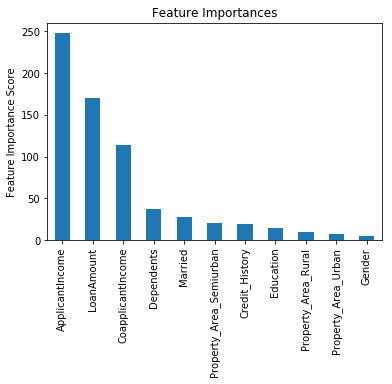

In [37]:
xgb3 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=6, min_child_weight=12, gamma=0.0, subsample=0.8,
                     colsample_bytree=0.95, reg_alpha=0.01, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb3, train, predictors)